# Bike-Sharing Dataset

This notebook analyzes the Capital Bikeshare system's rental data from 2011-2012. We'll explore how various factors influence bike rental patterns using advanced machine learning techniques.
The [Bike-Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) contains:
- 17,379 hourly records
- 14 features including temporal and weather information
- Target variable: hourly bike rental count

In [1]:
import effector
import numpy as np
import tensorflow as tf
from tensorflow import keras
import random

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-06-24 12:12:26.707704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preprocess the data

In [2]:
from ucimlrepo import fetch_ucirepo
bike_sharing_dataset = fetch_ucirepo(id=275)
X = bike_sharing_dataset.data.features
y = bike_sharing_dataset.data.targets

In [3]:
X = X.drop(["dteday", "atemp"], axis=1)

In [4]:
print("Design matrix shape: {}".format(X.shape))
print("---------------------------------")
for i, col_name in enumerate(X.columns):
    print("x_{} {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(i, col_name, len(X[col_name].unique()), X[col_name].mean(), X[col_name].std(), X[col_name].min(), X[col_name].max()))
    
print("\nTarget shape: {}".format(y.shape))
print("---------------------------------")
for col_name in y.columns:
    print("Target: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(col_name, len(y[col_name].unique()), y[col_name].mean(), y[col_name].std(), y[col_name].min(), y[col_name].max()))

Design matrix shape: (17379, 11)
---------------------------------
x_0 season         , unique:    4, Mean:   2.50, Std:   1.11, Min:   1.00, Max:   4.00
x_1 yr             , unique:    2, Mean:   0.50, Std:   0.50, Min:   0.00, Max:   1.00
x_2 mnth           , unique:   12, Mean:   6.54, Std:   3.44, Min:   1.00, Max:  12.00
x_3 hr             , unique:   24, Mean:  11.55, Std:   6.91, Min:   0.00, Max:  23.00
x_4 holiday        , unique:    2, Mean:   0.03, Std:   0.17, Min:   0.00, Max:   1.00
x_5 weekday        , unique:    7, Mean:   3.00, Std:   2.01, Min:   0.00, Max:   6.00
x_6 workingday     , unique:    2, Mean:   0.68, Std:   0.47, Min:   0.00, Max:   1.00
x_7 weathersit     , unique:    4, Mean:   1.43, Std:   0.64, Min:   1.00, Max:   4.00
x_8 temp           , unique:   50, Mean:   0.50, Std:   0.19, Min:   0.02, Max:   1.00
x_9 hum            , unique:   89, Mean:   0.63, Std:   0.19, Min:   0.00, Max:   1.00
x_10 windspeed      , unique:   30, Mean:   0.19, Std:   0.12, 

In [5]:
def preprocess(X, y):
    # Standarize X
    X_df = X
    x_mean = X_df.mean()
    x_std = X_df.std()
    X_df = (X_df - X_df.mean()) / X_df.std()

    # Standarize Y
    Y_df = y
    y_mean = Y_df.mean()
    y_std = Y_df.std()
    Y_df = (Y_df - Y_df.mean()) / Y_df.std()
    return X_df, Y_df, x_mean, x_std, y_mean, y_std

# shuffle and standarize all features
X_df, Y_df, x_mean, x_std, y_mean, y_std = preprocess(X, y)

In [6]:
def split(X_df, Y_df):
    # shuffle indices
    indices = X_df.index.tolist()
    np.random.shuffle(indices)
    
    # data split
    train_size = int(0.8 * len(X_df))
    
    X_train = X_df.iloc[indices[:train_size]]
    Y_train = Y_df.iloc[indices[:train_size]]
    X_test = X_df.iloc[indices[train_size:]]
    Y_test = Y_df.iloc[indices[train_size:]]
    
    return X_train, Y_train, X_test, Y_test

# train/test split
X_train, Y_train, X_test, Y_test = split(X_df, Y_df)


## Fit a Neural Network

In [7]:
# Train - Evaluate - Explain a neural network
model = keras.Sequential([
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae", keras.metrics.RootMeanSquaredError()])
model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1)
model.evaluate(X_train, Y_train, verbose=1)
model.evaluate(X_test, Y_test, verbose=1)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6231 - mae: 0.5745 - root_mean_squared_error: 0.7853
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3870 - mae: 0.4506 - root_mean_squared_error: 0.6219
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2976 - mae: 0.3851 - root_mean_squared_error: 0.5454
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2237 - mae: 0.3326 - root_mean_squared_error: 0.4728
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1619 - mae: 0.2836 - root_mean_squared_error: 0.4023
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1193 - mae: 0.2386 - root_mean_squared_error: 0.3451
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0906 - mae: 0.2075 - root_mean_squared_error: 0.3009
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0753 - mae: 0.1895 - root_mean_squared_error: 0.2745
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0669 - mae: 0.1784 - root_mea

[0.06317276507616043, 0.16644978523254395, 0.25134193897247314]

We train a deep fully-connected Neural Network with 3 hidden layers for \(20\) epochs. 
The model achieves a root mean squared error on the test of about $0.24$ units, that corresponds to approximately \(0.26 * 181 = 47\) counts.

## Explain

In [8]:
def model_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

def model_forward(x):
    return model(x).numpy().squeeze()

In [9]:
scale_y = {"mean": y_mean.iloc[0], "std": y_std.iloc[0]}
scale_x_list =[{"mean": x_mean.iloc[i], "std": x_std.iloc[i]} for i in range(len(x_mean))]
scale_x = scale_x_list[3]
feature_names = X_df.columns.to_list()
target_name = "bike-rentals"
y_limits=[-200, 800]
dy_limits = [-300, 300]

In [10]:
scale_x_list[8]["mean"] += 8
scale_x_list[8]["std"] *= 47

scale_x_list[9]["std"] *= 100
scale_x_list[10]["std"] *= 67

## PDP - analyze all features

We start by examining all relevant features. Feature effect methods are generally more meaningful for numerical features, so we focus on them.
Relevant features:

- `month`  
- `hr`  
- `weekday`  
- `workingday`  
- `temp`  
- `humidity`  
- `windspeed`

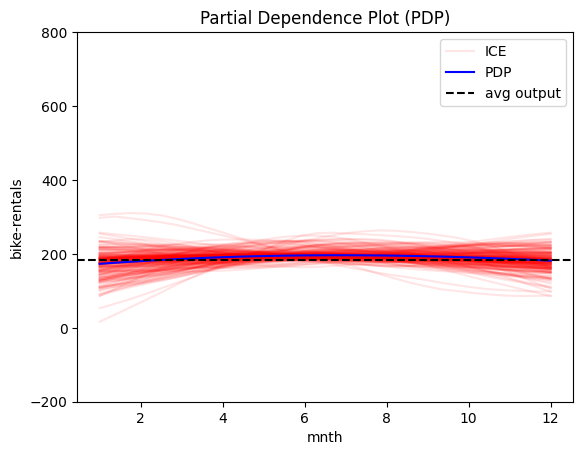

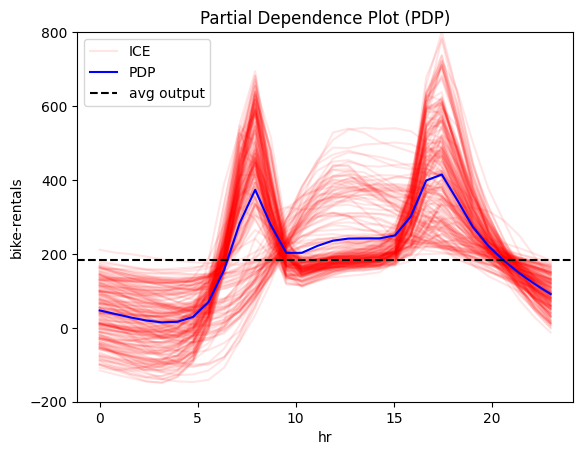

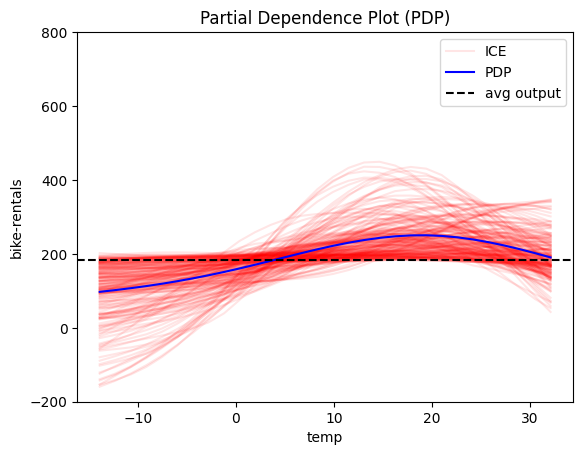

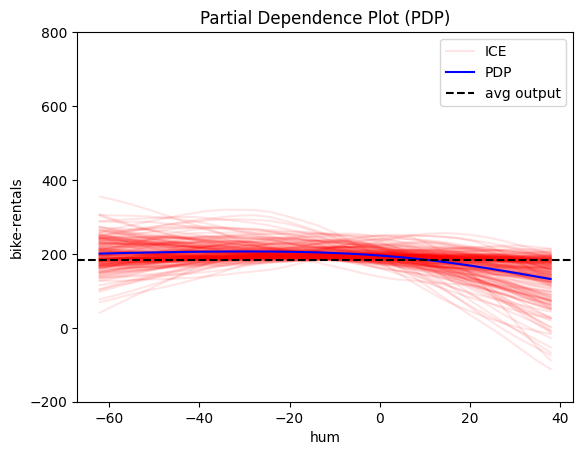

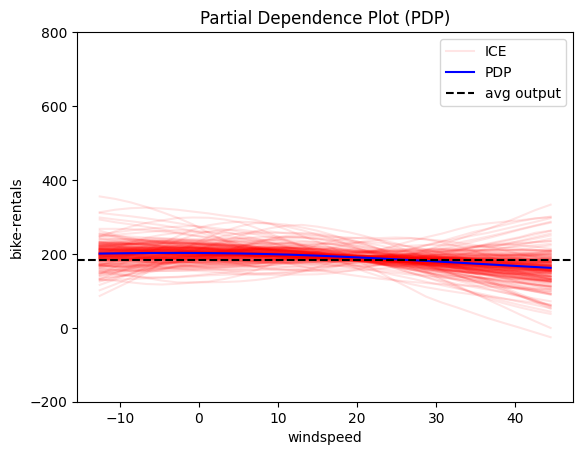

In [11]:
pdp = effector.PDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=2000)
for i in [2, 3, 8, 9, 10]:
    pdp.plot(feature=i, centering=True, scale_x=scale_x_list[i], scale_y=scale_y, show_avg_output=True, nof_ice=200, y_limits=y_limits)

We observe that features: `hour`, `temperature` and `humidity` have an intersting structure. Out of them `hour` has by far the most influence on the output, so it makes sensce to focus on it further.

## Feature `hour`

### PDP - global

2025-06-24 12:12:58.719189: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.
2025-06-24 12:12:58.843474: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.
2025-06-24 12:12:58.937027: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.
2025-06-24 12:12:59.827863: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.
2025-06-24 12:12:59.939911: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


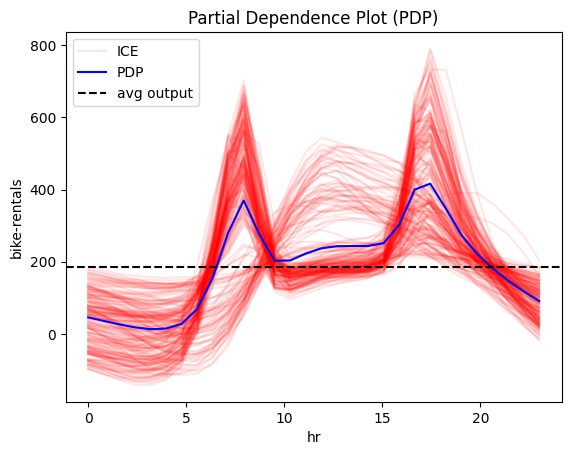

In [12]:
pdp = effector.PDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=5000)
pdp.plot(feature=3, centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True, nof_ice=200)

### PDP - regional

In [13]:
regional_pdp = effector.RegionalPDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, nof_instances=5_000)
regional_pdp.summary(features=3, scale_x_list=scale_x_list)

100%|██████████| 1/1 [00:02<00:00,  2.26s/it]



Feature 3 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
hr 🔹 [id: 0 | heter: 0.24 | inst: 5000 | w: 1.00]
    workingday = 0.00 🔹 [id: 1 | heter: 0.13 | inst: 1548 | w: 0.31]
        temp ≤ 4.50 🔹 [id: 2 | heter: 0.06 | inst: 618 | w: 0.12]
        temp > 4.50 🔹 [id: 3 | heter: 0.10 | inst: 930 | w: 0.19]
    workingday ≠ 0.00 🔹 [id: 4 | heter: 0.12 | inst: 3452 | w: 0.69]
        yr = 0.00 🔹 [id: 5 | heter: 0.06 | inst: 1719 | w: 0.34]
        yr ≠ 0.00 🔹 [id: 6 | heter: 0.11 | inst: 1733 | w: 0.35]
--------------------------------------------------
Feature 3 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.24
    Level 1🔹heter: 0.13 | 🔻0.12 (48.45%)
        Level 2🔹heter: 0.08 | 🔻0.04 (32.86%)




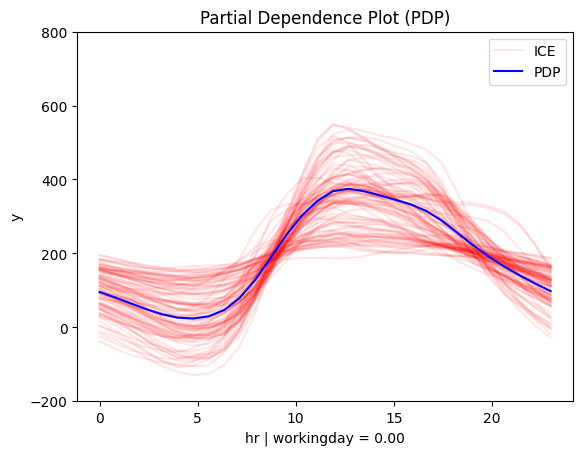

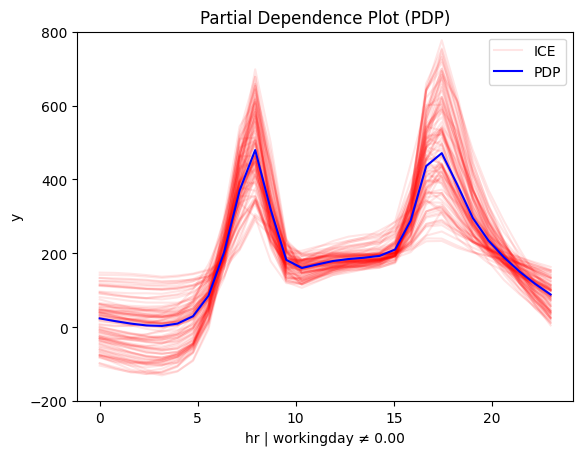

In [14]:
for node_idx in [1, 4]:
    regional_pdp.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

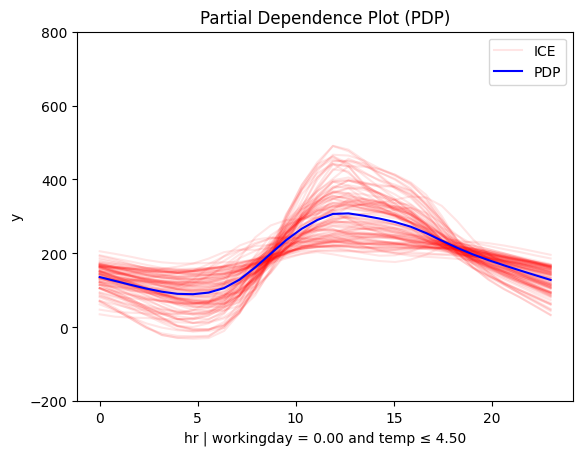

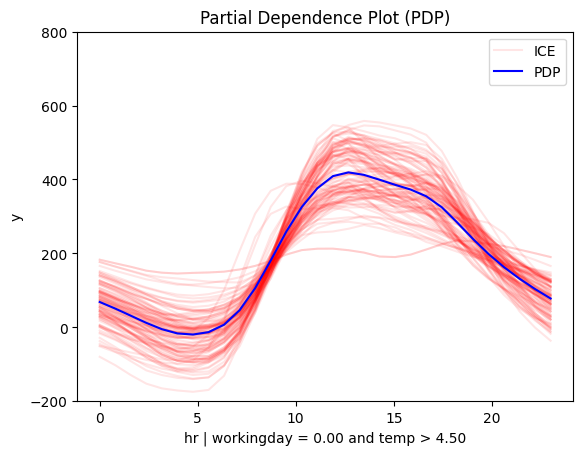

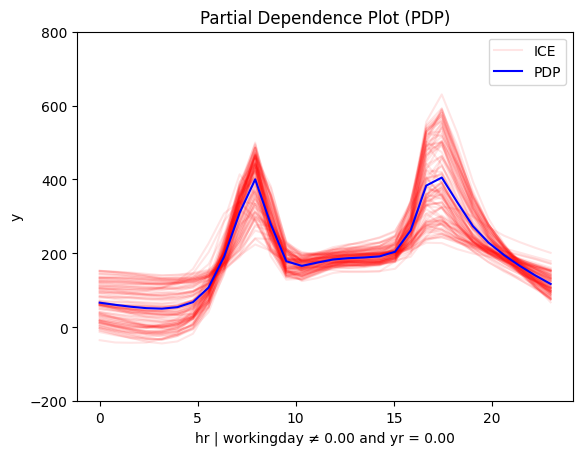

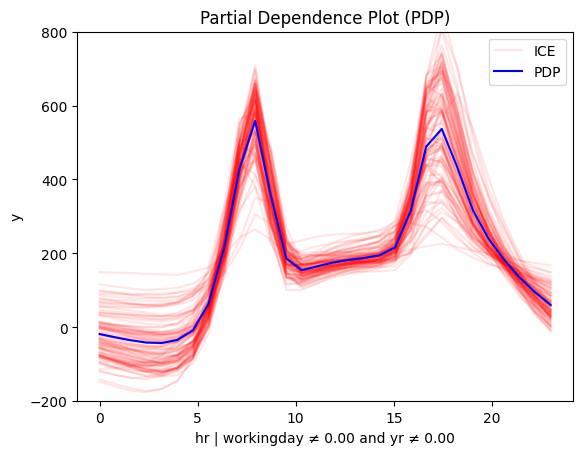

In [15]:
for node_idx in [2, 3, 5, 6]:
    regional_pdp.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

### RHALE - global

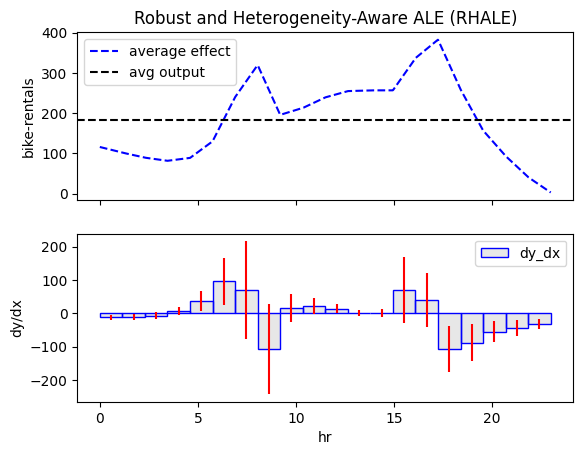

In [16]:
rhale = effector.RHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name)
rhale.plot(feature=3, heterogeneity="std", centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

### RHALE - regional

In [17]:
regional_rhale = effector.RegionalRHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name)
regional_rhale.summary(features=3, scale_x_list=scale_x_list)

100%|██████████| 1/1 [00:03<00:00,  3.60s/it]



Feature 3 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
hr 🔹 [id: 0 | heter: 5.68 | inst: 13903 | w: 1.00]
    workingday = 0.00 🔹 [id: 1 | heter: 0.75 | inst: 4385 | w: 0.32]
        temp ≤ 6.81 🔹 [id: 2 | heter: 0.44 | inst: 2187 | w: 0.16]
        temp > 6.81 🔹 [id: 3 | heter: 0.60 | inst: 2198 | w: 0.16]
    workingday ≠ 0.00 🔹 [id: 4 | heter: 5.44 | inst: 9518 | w: 0.68]
--------------------------------------------------
Feature 3 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 5.68
    Level 1🔹heter: 3.96 | 🔻1.71 (30.22%)
        Level 2🔹heter: 0.16 | 🔻3.80 (95.84%)




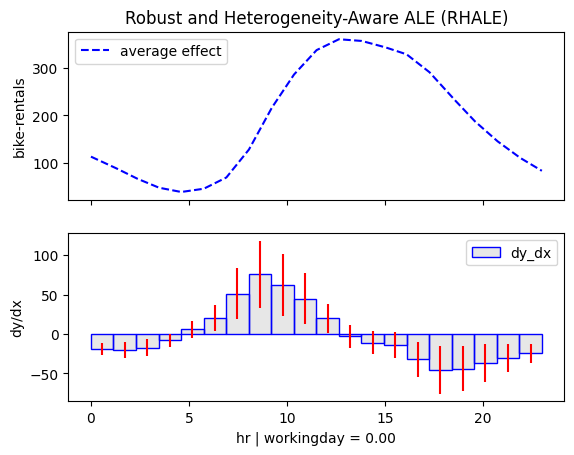

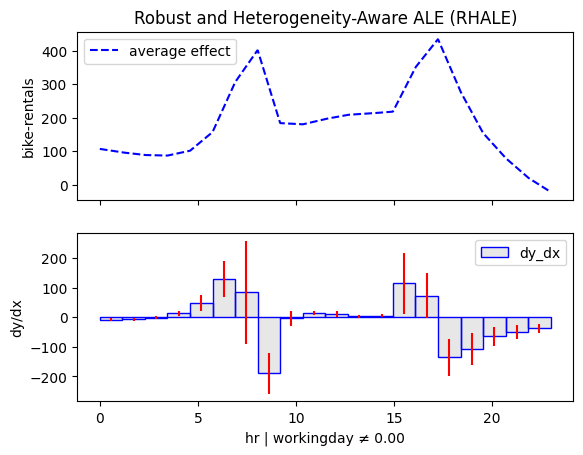

In [18]:
for node_idx in [1, 4]:
    regional_rhale.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y)

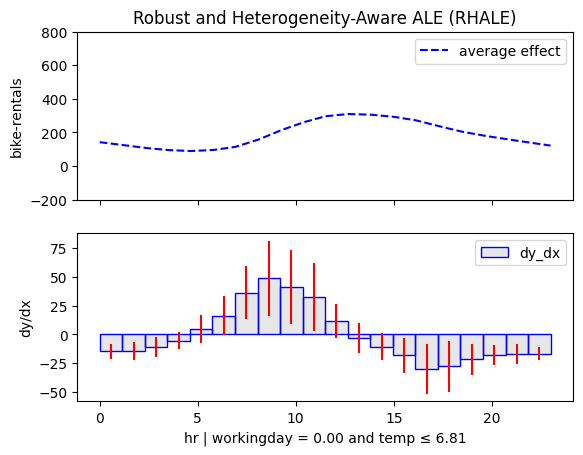

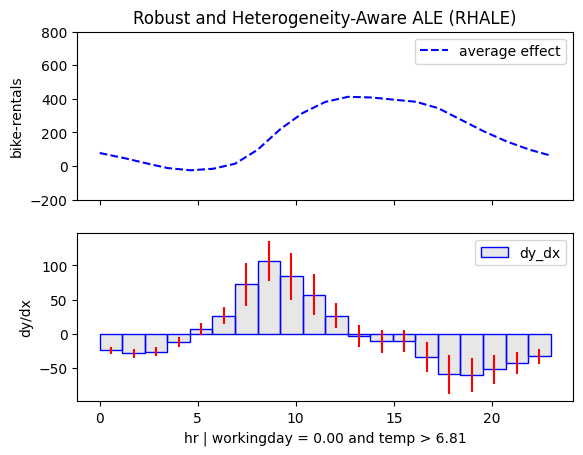

In [19]:
for node_idx in [2, 3]:
    regional_rhale.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

### SHAPDP - global

PermutationExplainer explainer: 501it [02:43,  2.91it/s]                         


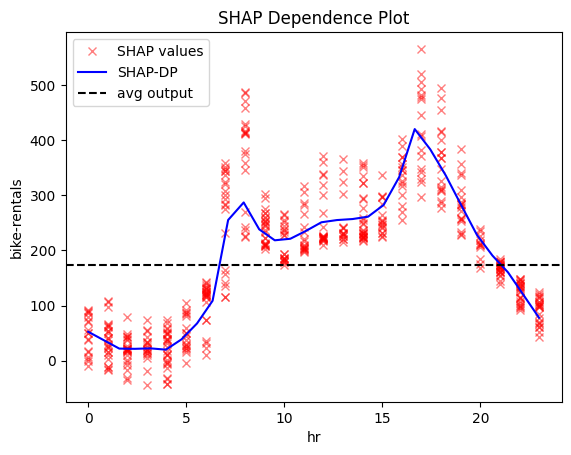

In [20]:
shap_dp = effector.ShapDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=500)
shap_dp.plot(feature=3, centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

### SHAPDP - regional

In [21]:
regional_shap_dp = effector.RegionalShapDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, nof_instances=500)
regional_shap_dp.summary(features=3, scale_x_list=scale_x_list)

PermutationExplainer explainer: 100%|██████████| 500/500 [02:23<00:00,  3.45it/s]
PermutationExplainer explainer: 501it [02:24,  3.22it/s]                         
100%|██████████| 1/1 [02:25<00:00, 145.14s/it]



Feature 3 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
hr 🔹 [id: 0 | heter: 0.05 | inst: 500 | w: 1.00]
    workingday = 0.00 🔹 [id: 1 | heter: 0.02 | inst: 158 | w: 0.32]
        temp ≤ 9.11 🔹 [id: 2 | heter: 0.02 | inst: 92 | w: 0.18]
        temp > 9.11 🔹 [id: 3 | heter: 0.01 | inst: 66 | w: 0.13]
    workingday ≠ 0.00 🔹 [id: 4 | heter: 0.03 | inst: 342 | w: 0.68]
        yr = 0.00 🔹 [id: 5 | heter: 0.02 | inst: 169 | w: 0.34]
        yr ≠ 0.00 🔹 [id: 6 | heter: 0.02 | inst: 173 | w: 0.35]
--------------------------------------------------
Feature 3 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.05
    Level 1🔹heter: 0.03 | 🔻0.03 (51.02%)
        Level 2🔹heter: 0.02 | 🔻0.01 (30.09%)




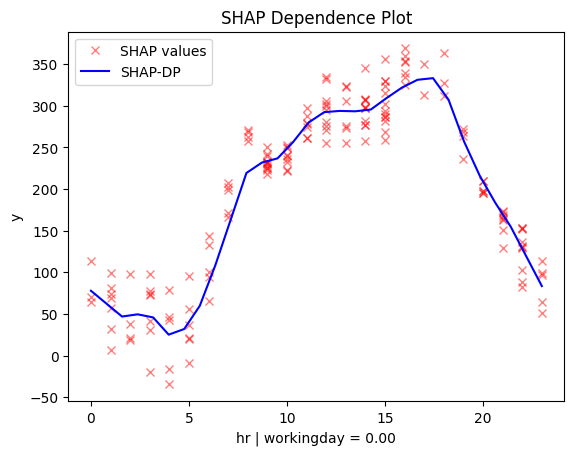

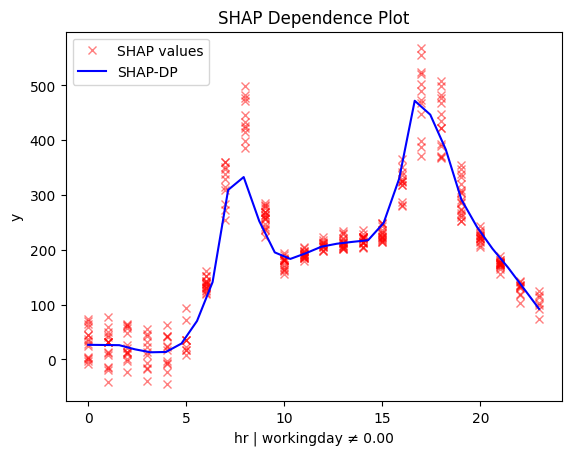

In [22]:
for node_idx in [1, 4]:
    regional_shap_dp.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y)

/home/givasile/github/packages/effector/effector/global_effect_shap.py:469: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.feature_effect["feature_" + str(feature)]["spline_std"](x))


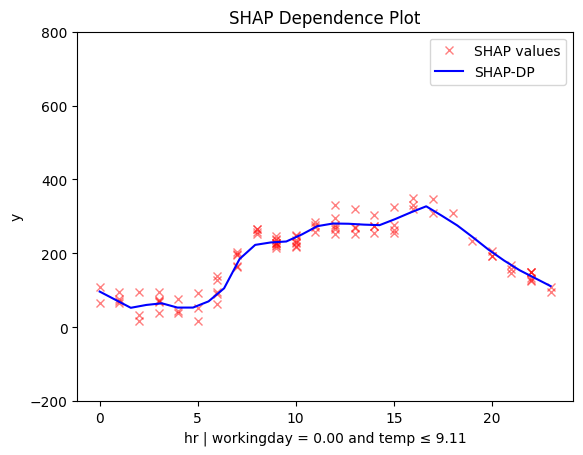

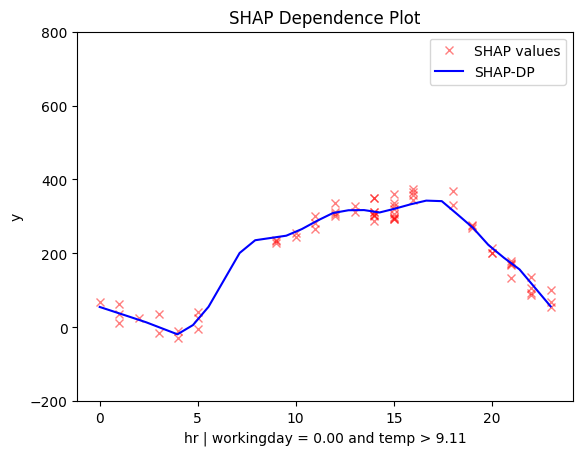

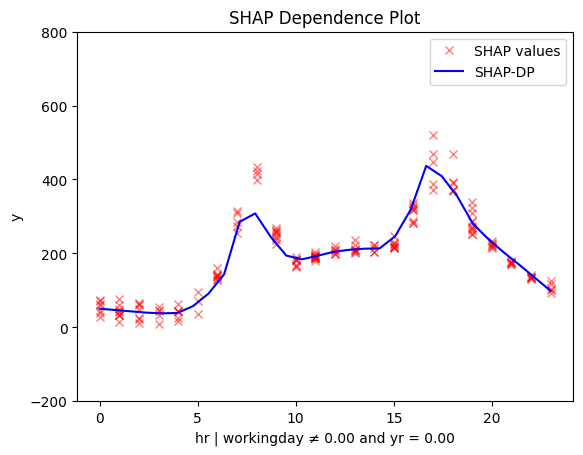

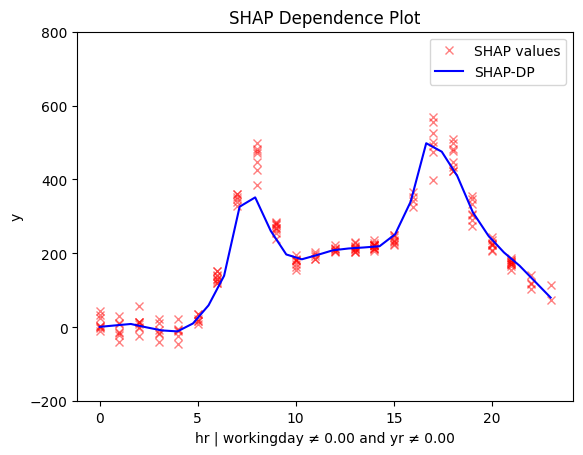

In [23]:
for node_idx in [2, 3, 5, 6]:
    regional_shap_dp.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

## Conclusion

**Global effect of hour**
All methods agree: *hour* has a strong influence on bike rentals, showing two clear peaks—around **8:00** and **17:00**. This likely reflects commute times. But the exact shape of the effect varies between methods, hinting that local (regional) patterns could help explain these differences.

**Regional effect of hour**
When we zoom in using regional methods, two patterns emerge:

* **On working days**, the effect follows the global trend, with peaks at **8:00** and **17:00**—again, probably due to commuting.
* **On non-working days**, we see a single peak around **13:00**, which makes sense if people are out enjoying leisure activities or sightseeing.

All methods agree up to this point.

**Interactions**
Looking deeper, we see some interesting (but weaker) interactions. Most methods highlight either **temperature** or **year** (whether it’s the first or second year of data) as relevant.

For example, RHALE shows that on **non-working days**, the midday peak (12:00–14:00) becomes even stronger when the **temperature is higher**. That fits our intuition—people are more likely to rent bikes when it’s warm and sunny.